In [5]:
import torch
import torch.nn as nn
from torch.nn import functional as F

from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="/home/zach/intelligent_machines/data",
    train=True,
    download=False,
    transform=transforms.ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="/home/zach/intelligent_machines/data",
    train=False,
    download=False,
    transform=transforms.ToTensor(),
)

print(training_data.data.shape)
print(test_data.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


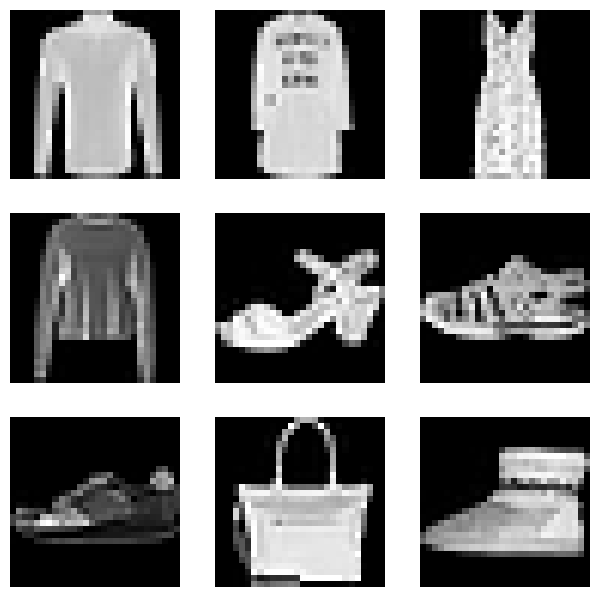

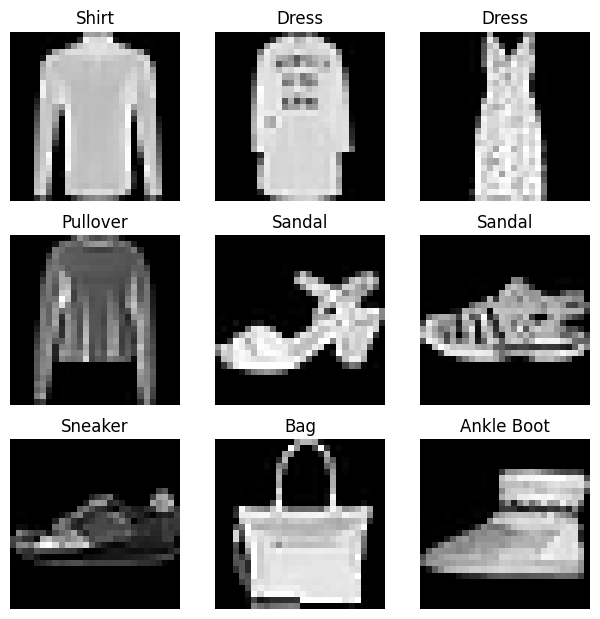

In [44]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
cols, rows = 3, 3

# Store images and labels
img_display = []

for i in range(cols * rows):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    img_display.append((img, label))



figure = plt.figure(figsize=(cols*2.5, rows*2.5))

for i in range(cols * rows):
    img, label = img_display[i]
    figure.add_subplot(rows, cols, i+1)
    # plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")


figure = plt.figure(figsize=(cols*2.5, rows*2.5))

for i in range(cols * rows):
    img, label = img_display[i]
    figure.add_subplot(rows, cols, i+1)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

plt.show()

In [45]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")


Using cuda device


In [27]:

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 10),
            # nn.ReLU(),
            # nn.Linear(512, 512),
            # nn.ReLU(),
            # nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
  )
)


In [28]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [14]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [13]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [33]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.726901  [   64/60000]
loss: 0.814385  [ 6464/60000]
loss: 0.580452  [12864/60000]
loss: 0.841289  [19264/60000]
loss: 0.703136  [25664/60000]
loss: 0.712373  [32064/60000]
loss: 0.772960  [38464/60000]
loss: 0.747038  [44864/60000]
loss: 0.787207  [51264/60000]
loss: 0.724285  [57664/60000]
Test Error: 
 Accuracy: 76.2%, Avg loss: 0.723919 

Epoch 2
-------------------------------
loss: 0.709107  [   64/60000]
loss: 0.797757  [ 6464/60000]
loss: 0.565319  [12864/60000]
loss: 0.828003  [19264/60000]
loss: 0.691821  [25664/60000]
loss: 0.699490  [32064/60000]
loss: 0.759157  [38464/60000]
loss: 0.737962  [44864/60000]
loss: 0.776526  [51264/60000]
loss: 0.711868  [57664/60000]
Test Error: 
 Accuracy: 76.6%, Avg loss: 0.711376 

Epoch 3
-------------------------------
loss: 0.693442  [   64/60000]
loss: 0.782823  [ 6464/60000]
loss: 0.552078  [12864/60000]
loss: 0.816094  [19264/60000]
loss: 0.681792  [25664/60000]
loss: 0.688040  [32064/600

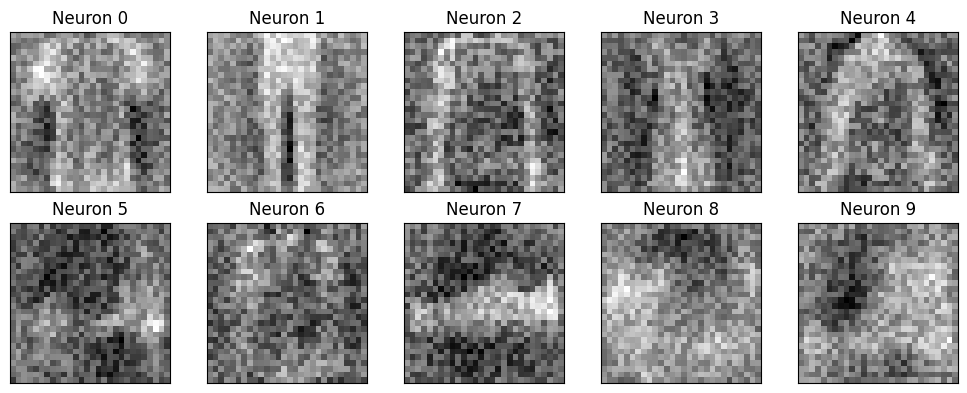

In [31]:
# Get the first layer's weights
first_layer_weights = model.linear_relu_stack[0].weight.detach().cpu().numpy()

# Normalize for better visualization
min_w, max_w = first_layer_weights.min(), first_layer_weights.max()
normalized_weights = (first_layer_weights - min_w) / (max_w - min_w)

# Plot the weights as images
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(normalized_weights[i].reshape(28, 28), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Neuron {i}")

plt.tight_layout()
plt.show()

In [15]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [16]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

In [19]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"
